# Time series analysis

In [13]:

import pandas as pd
import matplotlib
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import scipy

# Data

import dataset: "data3.csv", the frist row has a Nan value

importazione del dataset : "data3.csv"

In [14]:
data= pd.read_csv("data3.csv", sep=';', header=None)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   object 
 1   1       1001 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [16]:
data.head()

,0,1
0,NaN,0.00
1,2023-01-01,0.00
2,2023-01-02,-0.30
3,2023-01-03,-0.24
4,2023-01-04,-1.49


In [17]:
print(data.isnull().sum())

0    1
1    0
dtype: int64


In [18]:
data = data.iloc[1:].reset_index(drop=True) # rimuove prima riga con NaN

# Converte le colonne
data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors="coerce")
data.iloc[:, 1] = pd.to_numeric(data.iloc[:, 1], errors="coerce")

# Rinomina le colonne
data.columns = ["date", "value"]

# Imposta l'indice
data = data.set_index("date")

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-01-01 to 2025-09-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [20]:
data.head()

,value
date,
2023-01-01,0.00
2023-01-02,-0.30
2023-01-03,-0.24
2023-01-04,-1.49
2023-01-05,-1.86


# Data plot

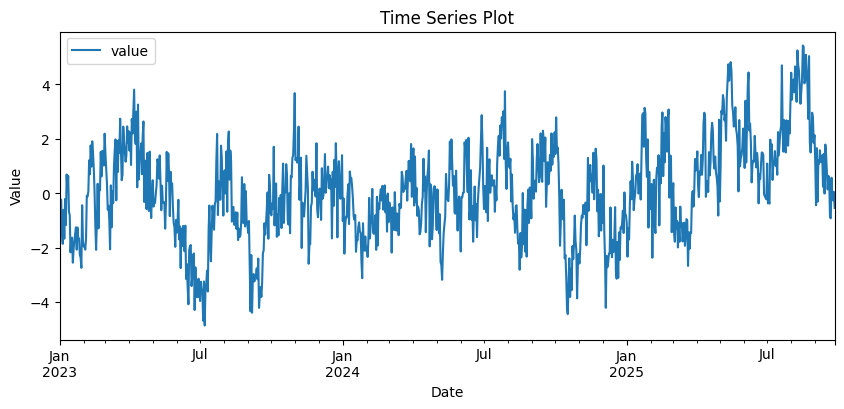

In [21]:
import matplotlib.pyplot as plt

data.plot(figsize=(10,4)) # grafico serie temporale
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Plot")
plt.show()

# Stationarity

## ADF test

In [22]:
from statsmodels.tsa.stattools import adfuller

ts_value = data["value"]

# Test di Dickey-Fuller aumentato
result = adfuller(ts_value, autolag="AIC")

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used lags:", result[2])
print("Number of observations:", result[3])
print("Critical Values:", result[4])

if result[1] < 0.05:
    print("➡️ La serie è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie NON è stazionaria (non rifiuto H0)")

ADF Statistic: -5.2823476214828755
p-value: 5.956008263602224e-06
Used lags: 2
Number of observations: 997
Critical Values: {'1%': np.float64(-3.4369259442540416), '5%': np.float64(-2.8644432969122833), '10%': np.float64(-2.5683158550174094)}
➡️ La serie è stazionaria (rifiuto H0)


## KPSS test

In [23]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(ts_value, regression='c', nlags='auto')
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Critical Values:", kpss_result[3])

alpha = 0.05
if kpss_result[1] < alpha:
    print("➡️ La serie NON è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie è stazionaria (non rifiuto H0)")

KPSS Statistic: 1.1248573426155892
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
➡️ La serie NON è stazionaria (rifiuto H0)


/tmp/ipython-input-738478077.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts_value, regression='c', nlags='auto')


# ACF & PACF


Based on the ACF and PACF plots, we assume an AR(3) model.

Si tracciano i correlogrammi ACF e PACF: si suppone un modello AR(3)

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + \varepsilon_t,
\qquad \varepsilon_t \sim WN(0, \sigma^2)
$$


<Figure size 640x480 with 0 Axes>

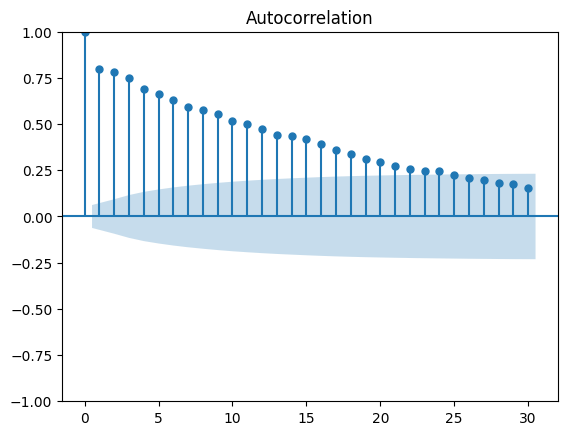

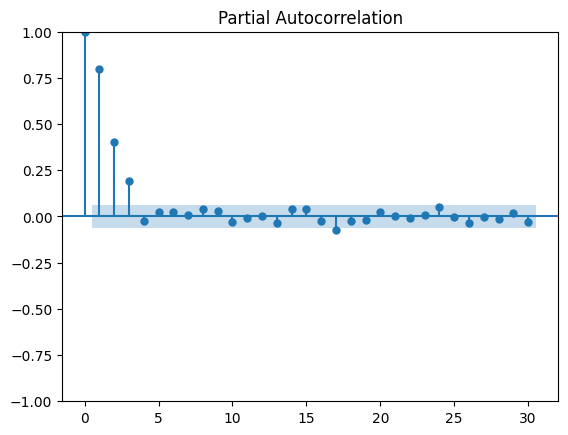

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF e PACF
fig = plt.figure()
plot_acf(data['value'], lags=30)
plot_pacf(data['value'], lags=30)
plt.show()

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(data["value"], lags=[10], return_df=True)
print(lb_test)

        lb_stat  lb_pvalue
10  4407.846959        0.0


# Model


## Modello AR(3)

Il modello stimato con `AutoReg` è:

$$
X_t = 0.0055 \;+\; 0.3959 \, X_{t-1} \;+\; 0.3140 \, X_{t-2} \;+\; 0.1919 \, X_{t-3} \;+\; \varepsilon_t
$$

dove $\varepsilon_t \sim WN(0, \sigma^2)$ con deviazione standard stimata
$\hat{\sigma} = 0.955$.

### Interpretazione

- **Costante** = 0.0055 (non significativa, p = 0.855)  
- **AR(1)** = 0.3959 (significativo, p < 0.001)  
- **AR(2)** = 0.3140 (significativo, p < 0.001)  
- **AR(3)** = 0.1919 (significativo, p < 0.001)  

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(data, lags=3, old_names=False)    # lags=3 -> AR(3)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                 1000
Model:                     AutoReg(3)   Log Likelihood               -1369.222
Method:               Conditional MLE   S.D. of innovations              0.955
Date:                Mon, 29 Sep 2025   AIC                           2748.444
Time:                        13:08:41   BIC                           2772.968
Sample:                    01-04-2023   HQIC                          2757.766
                         - 09-26-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.030      0.182      0.855      -0.054       0.065
value.L1       0.3959      0.031     12.736      0.000       0.335       0.457
value.L2       0.3140      0.032      9.809      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Residual diagnostics

The model diagnostics were successful because the residuals behave like white noise.

La diagnostica del modello è andata a buon fine poiché i residui si comportano come rumore bianco.

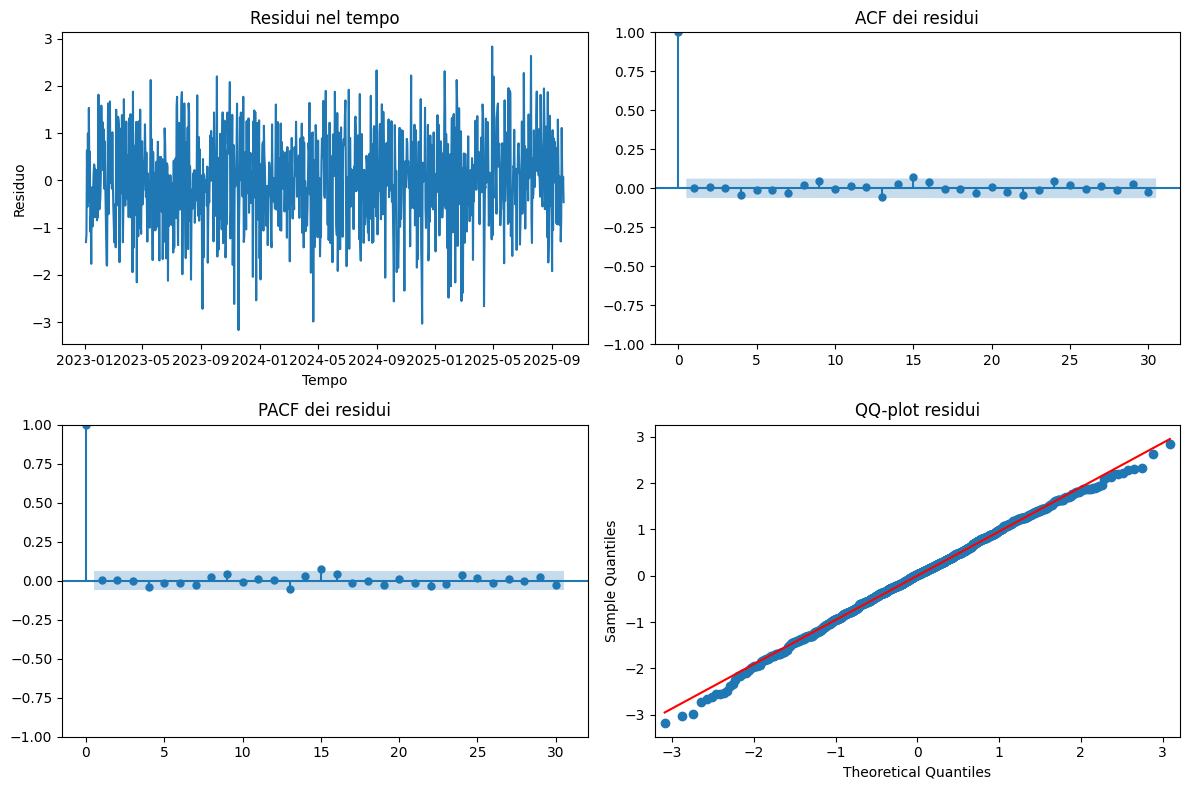

Ljung-Box test residui:
      lb_stat  lb_pvalue
10   5.578542   0.849343
20  17.487146   0.621152
30  24.147158   0.765326
Jarque–Bera: stat = 4.389, p-value = 0.111


In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

resid = res.resid  # residui del modello


fig, axes = plt.subplots(2, 2, figsize=(12,8))

# 1. Serie temporale dei residui
axes[0,0].plot(resid)
axes[0,0].set_title("Residui nel tempo")
axes[0,0].set_xlabel("Tempo")
axes[0,0].set_ylabel("Residuo")

# 2. ACF dei residui
plot_acf(resid, lags=30, ax=axes[0,1])
axes[0,1].set_title("ACF dei residui")

# 3. PACF dei residui
plot_pacf(resid, lags=30, ax=axes[1,0])
axes[1,0].set_title("PACF dei residui")

# 4. QQ plot (normalità visiva)
sm.qqplot(resid, line="s", ax=axes[1,1])
axes[1,1].set_title("QQ-plot residui")

plt.tight_layout()
plt.show()

# Test Ljung-Box
lb = acorr_ljungbox(resid, lags=[10,20,30], return_df=True)
print("Ljung-Box test residui:")
print(lb)

# Test Jarque-Bera
jb_stat, jb_pvalue = jarque_bera(resid)
print(f"Jarque–Bera: stat = {jb_stat:.3f}, p-value = {jb_pvalue:.3f}")